In [1]:
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

from chainercv.datasets import VOCBboxDataset
from chainercv.datasets import voc_bbox_label_names
from chainercv.visualizations import vis_bbox
from chainer import iterators
import torch
import torch.nn as nn
import torch.nn.functional as functional
from DataLoader import ImageDataset
import numpy as np
from panet import PanNet
from panet import IOULoss

from panet import EncoderNet

31518
22083
4699
4736
31518


In [2]:
csv_path = "./DL_info.csv"
Image_slices_dir = "/home/parv/Dropbox/Final_Images_2/"



In [3]:
train_dataset = ImageDataset(root_dir = Image_slices_dir, dataset_type=1)
validation_dataset = ImageDataset(root_dir = Image_slices_dir, dataset_type=2)
test_dataset = ImageDataset(root_dir = Image_slices_dir, dataset_type=3)

In [4]:
train_dataset[0]

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'labels': array([1.]),
 'lesions': tensor([[345.9880, 284.4280, 372.5360, 319.9120]])}

In [4]:
##using dataloader for batch trainig 
batch_size=2
dataloader_train=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
print (len(dataloader_train))

dataloader_validation=torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size,shuffle=False)
print (len(dataloader_validation))

dataloader_test=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
print (len(dataloader_test))

11042
2350
2368


In [6]:
# Just a debug loop
for i in range(100):
    train_dataset[i]

In [5]:
# Load the model
model = PanNet().cuda()
# model.load_state_dict(torch.load('./model_'))
# model.cuda()

In [8]:
# The parameters for learning
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
criterion2 = nn.MSELoss()
criterion1 = IOULoss()

num_epochs = 1

In [9]:
Running_training_loss_list = []
Validation_loss_list = []

def validation_loop():
    loss_validation = 0
    count = 0
    for sample_batched in dataloader_validation:
        model.eval()
        # out1, out2 = model(sample_batched['image'].cuda())
        out1 = model(sample_batched['image'].cuda())
        loss = criterion2(out1, sample_batched['lesions'].cuda()) #+ (1e-6)*criterion2(out2, sample_batched['image'].cuda())
        count+=1
        Loss_val = loss.cpu().detach().item()
        loss_validation = loss_validation + Loss_val
        torch.cuda.empty_cache()
    final_loss = (loss_validation*1.0)/count
    print("===============================")
    print("Validation loss is ", final_loss)
    print("===============================")
    Validation_loss_list.append(final_loss)


In [10]:
############################################################
######Training Loop#########################################
for epoch in range(num_epochs):
    Running_loss = 0
    count = 0
    
    for sample_batched in dataloader_train:
        model.train()
#         print (sample_batched['image'].dtype)
#         print (sample_batched['lesions'].dtype)
#         out1, out2 = model(sample_batched['image'].cuda())
        out1 = model(sample_batched['image'].cuda())
        print (out1)
        print(sample_batched['lesions'])
        #print (out.shape)
        #print (sample_batched['lesions'].shape)
        loss = criterion2(out1, sample_batched['lesions'].cuda()) #+ (1e-6)*criterion2(out2, sample_batched['image'].cuda())
        # Store val in outer variable for printing
#         print (out)
        Loss_val = loss.cpu().detach().item()
        Running_loss = Running_loss + Loss_val
#         print (out[0])
#         print (sample_batched['lesions'][0])
        count += 1
        print ("Batch Loss", Loss_val)
        print ("Running Loss", Running_loss/count)
        #### Measure per image running loss for training set EVERY 50 batches
        if count%50==0:
            Running_training_loss_list.append(Running_loss/(count))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        #### Measure per image running loss for validation set EVERY 50 batches
        if count%50 == 0:
            sample_batched['image'].cpu().detach()
            sample_batched['lesions'].cpu().detach()
            validation_loop()
#         scheduler.step()

#     data0.cpu().detach()
#     data1.cpu().detach()
#     loss.cpu().detach()
    print ("Running Loss", Running_loss/count)

tensor([[[0.0000, 0.4463, 0.0000, 0.0000]],

        [[0.0000, 0.2558, 0.0062, 0.1005]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[[345.9880, 284.4280, 372.5360, 319.9120]],

        [[230.4030, 280.8390, 262.5840, 315.3970]]])
Batch Loss 92706.453125
Running Loss 92706.453125
tensor([[[ 0.0000, 58.4029,  3.8198,  7.7026]],

        [[ 0.0000, 64.8905,  3.7676,  7.5625]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[[306.3770, 270.4350, 320.9030, 286.2920]],

        [[288.2000, 266.0440, 308.3200, 287.8060]]])
Batch Loss 76473.6015625
Running Loss 84590.02734375
tensor([[[  0.0000, 143.7320,  57.1439,  67.1714]],

        [[  0.0000, 152.7003,  62.0680,  72.8963]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[[302.7630, 183.8820, 321.9270, 204.0360]],

        [[296.7690, 213.7510, 313.5060, 228.5060]]])
Batch Loss 45169.2421875
Running Loss 71449.765625
tensor([[[  0.0000, 234.8176, 176.5975, 145.2817]],

        [[  0.0000, 236.3281, 177.

tensor([[[  0.0000, 254.3243, 271.5308, 304.2104]],

        [[  0.0000, 295.9317, 314.4367, 353.4601]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[[158.3100, 228.4513, 175.5233, 247.6607]],

        [[196.9840, 287.9150, 215.7870, 309.1940]]])
Batch Loss 11088.123046875
Running Loss 25815.918294270832
tensor([[[  0.0000, 262.4259, 275.8517, 309.0201]],

        [[  0.0000, 275.8259, 290.0910, 322.5291]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[[154.0670, 211.9850, 173.1460, 233.5400]],

        [[189.2300, 258.6190, 208.1940, 284.8800]]])
Batch Loss 10844.41015625
Running Loss 25281.221575055803
tensor([[[  0.0000, 226.1465, 232.3925, 263.8832]],

        [[  0.0000, 270.7687, 275.5659, 316.0362]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[[161.3540, 187.2350, 179.8560, 206.4450]],

        [[199.0400, 276.3680, 219.6700, 299.1910]]])
Batch Loss 9583.10546875
Running Loss 24739.9072265625
tensor([[[  0.0000, 211.0152, 206.9292, 247.1

KeyboardInterrupt: 

In [12]:
model.cpu()
torch.save(model.state_dict(), './model_')

In [17]:
model = model.cpu()
count = 0
loss_validation = 0
for sample_batched in dataloader_test:
    model.eval()
    out = model(sample_batched['image'])
    print (out[0].shape)
    print (sample_batched['lesions'].shape)

    loss = criterion1(out[0], sample_batched['lesions'])
    count+=1
    Loss_val = loss.cpu().detach().item()
    print ("Batch Loss", Loss_val)
    loss_validation = loss_validation + Loss_val
    print ("Running Loss", loss_validation/count)
    
#     print (sample_batched['image'][0].numpy().shape)
#     img = sample_batched['image'][0].view(512, 512, 3)
#     #print(img.size())
#     img = img.numpy()
#     print(img.shape)
    #lesions = sample_batched['image'][1]
    #plt.figure()
    #plt.imshow(img)
#     for i in range(lesions.shape[0]):
#         plt.gca().add_patch(plt.Rectangle((lesions[i][0],lesions[i][1]),
#                             lesions[i][2]-lesions[i][0],
#                             lesions[i][3]-lesions[i][1],
#                             linewidth=1,edgecolor='r', fill=False))
#     lesions = out[0].numpy()
#     for i in range(lesions.shape[0]):
#         plt.gca().add_patch(plt.Rectangle((lesions[i][0],lesions[i][1]),
#                             lesions[i][2]-lesions[i][0],
#                             lesions[i][3]-lesions[i][1],
#                            linewidth=1,edgecolor='r', fill=False))
#     plt.imshow(img)
#     plt.show()
#     print (img.shape)


torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9434705972671509
Running Loss 1.9434705972671509
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.880411386489868
Running Loss 2.4119409918785095
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.078681707382202
Running Loss 2.3008545637130737
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9833885431289673
Running Loss 2.221488058567047
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9082143306732178
Running Loss 2.158833312988281
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9365746974945068
Running Loss 2.1217902104059854
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0293660163879395
Running Loss 2.108586754117693
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0435173511505127
Running Loss 2.1004530787467957
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0368893146514893
Running Loss 2.0933904382917614
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch L

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.901582717895508
Running Loss 1.9912797016433523
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8993701934814453
Running Loss 1.9901308327913285
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss -0.765838623046875
Running Loss 1.956106518521721
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.08398175239563
Running Loss 1.957665972593354
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8385918140411377
Running Loss 1.9562313441770622
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1310949325561523
Running Loss 1.9583130535625277
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7726646661758423
Running Loss 1.9561289548873901
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9494279623031616
Running Loss 1.956051036368969
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0126097202301025
Running Loss 1.9567011361834648
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Lo

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9312231540679932
Running Loss 1.9467848789919713
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.057950496673584
Running Loss 1.9474884588507158
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.914466142654419
Running Loss 1.9472807713274687
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.888357162475586
Running Loss 1.9469124987721442
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8486233949661255
Running Loss 1.9463020074441566
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1394495964050293
Running Loss 1.9474942765118164
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8648320436477661
Running Loss 1.9469871462488466
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0308313369750977
Running Loss 1.9474983913142507
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8273589611053467
Running Loss 1.9467702735554089
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.083726644515991
Running Loss 1.8862776525477145
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.5180184841156006
Running Loss 1.8889545204780869
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7772880792617798
Running Loss 1.8884833540594528
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.221442699432373
Running Loss 1.8898823429055576
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 4.027534484863281
Running Loss 1.898826494127138
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7683857679367065
Running Loss 1.8982829911013444
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.2174594402313232
Running Loss 1.899607374707693
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.2113571166992188
Running Loss 1.900895596782038
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.331150531768799
Running Loss 1.9026661932223128
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Los

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.977352499961853
Running Loss 1.9284653497961002
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.010606050491333
Running Loss 1.9287269443843016
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9959595203399658
Running Loss 1.9289403811333672
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.090604782104492
Running Loss 1.929451977338972
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8334071636199951
Running Loss 1.929148996854054
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.101957321166992
Running Loss 1.929692419257554
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0668907165527344
Running Loss 1.9301225079638082
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.072941780090332
Running Loss 1.9305688181892038
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.855297565460205
Running Loss 1.9303343283053127
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7611911296844482
Running Loss 1.9230220718761843
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8703725337982178
Running Loss 1.922887761830067
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1155426502227783
Running Loss 1.9233779778310665
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8501685857772827
Running Loss 1.923192167191336
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8855862617492676
Running Loss 1.923096962367432
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.04837965965271
Running Loss 1.9234133328151222
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9986845254898071
Running Loss 1.9236029327966704
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8655986785888672
Running Loss 1.92345719346449
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.140805721282959
Running Loss 1.9240019266169173
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8251800537109375
Running Loss 1.9407789177223564
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.319408655166626
Running Loss 1.941584512908408
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.040510654449463
Running Loss 1.9417945471791958
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.025611162185669
Running Loss 1.9419721247533621
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7640907764434814
Running Loss 1.9415960542495356
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.746229648590088
Running Loss 1.941183888836752
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0491878986358643
Running Loss 1.941411265699487
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.6689133644104004
Running Loss 1.940838791116947
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.909200668334961
Running Loss 1.940772463815517
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss -

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1086184978485107
Running Loss 1.9219282650860399
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1152915954589844
Running Loss 1.9222811178786912
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1551289558410645
Running Loss 1.9227052487310816
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.016097068786621
Running Loss 1.9228750520402735
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7498836517333984
Running Loss 1.9225610930560504
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8993942737579346
Running Loss 1.9225191241805104
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9533238410949707
Running Loss 1.9225748289127247
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.046046733856201
Running Loss 1.922797702387352
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.056220054626465
Running Loss 1.923038103022017
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch L

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9257339239120483
Running Loss 1.9079706568717956
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0441384315490723
Running Loss 1.9081881772786284
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7970707416534424
Running Loss 1.9080109564881576
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9207439422607422
Running Loss 1.9080312319432096
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7861018180847168
Running Loss 1.9078373854982833
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0094149112701416
Running Loss 1.9079986196661753
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7155262231826782
Running Loss 1.9076935920964708
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7041423320770264
Running Loss 1.907371517317959
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.0172698497772217
Running Loss 1.9059653535461727
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Bat

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 6.282296657562256
Running Loss 1.9413849680895148
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.195991039276123
Running Loss 1.941746624440632
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.932776689529419
Running Loss 1.9417339011287014
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.024444103240967
Running Loss 1.9418510543894836
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.08262300491333
Running Loss 1.9420501660592486
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss -0.8833363056182861
Running Loss 1.938059507200947
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9021774530410767
Running Loss 1.938008897815672
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.3540377616882324
Running Loss 1.9371864032577462
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8856346607208252
Running Loss 1.9371138972907462
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.843188762664795
Running Loss 1.8803828468548656
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.6239588260650635
Running Loss 1.8800549388998915
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8684279918670654
Running Loss 1.8800400896699645
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0256333351135254
Running Loss 1.880225795340173
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.6671624183654785
Running Loss 1.8799543770255556
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7817471027374268
Running Loss 1.8798294313839676
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0164852142333984
Running Loss 1.8800030727853012
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 0.37773650884628296
Running Loss 1.8780966431356323
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.978121042251587
Running Loss 1.8782234167720278
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batc

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9011194705963135
Running Loss 1.8809581132512432
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0992815494537354
Running Loss 1.8812119777119436
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.5912258625030518
Running Loss 1.8820366163702376
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9591948986053467
Running Loss 1.882126127138492
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.875913381576538
Running Loss 1.8821189281285706
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0549769401550293
Running Loss 1.8823189952721198
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0349411964416504
Running Loss 1.8824954371231828
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9228941202163696
Running Loss 1.8825420868727132
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9903724193572998
Running Loss 1.8826664586518187
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batc

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1169729232788086
Running Loss 1.9340739629948025
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7836637496948242
Running Loss 1.933913610955037
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.4224164485931396
Running Loss 1.9344338482688157
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9027931690216064
Running Loss 1.934400187971744
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.2625701427459717
Running Loss 1.9347489339385606
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.267179489135742
Running Loss 1.9351018326171139
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9387562274932861
Running Loss 1.9351057079033027
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9544522762298584
Running Loss 1.9351262021494113
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 0.32014745473861694
Running Loss 1.933417229929929
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.986495018005371
Running Loss 1.9389371903659087
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9618295431137085
Running Loss 1.9389597222091646
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0151028633117676
Running Loss 1.9390345925543981
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9637089967727661
Running Loss 1.9390588306724907
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9717354774475098
Running Loss 1.9390908980392965
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0314266681671143
Running Loss 1.9391814233041278
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.037672281265259
Running Loss 1.939277888395177
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 3.3264517784118652
Running Loss 1.940635201399107
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.6381208896636963
Running Loss 1.9403394884844096
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.594631552696228
Running Loss 1.9430982978215265
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.016885995864868
Running Loss 1.9431657454431384
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.924161434173584
Running Loss 1.9431483899077324
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8415937423706055
Running Loss 1.9430557305577898
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9549168348312378
Running Loss 1.9430665428679752
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7635812759399414
Running Loss 1.9429030772332503
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.058117389678955
Running Loss 1.9430079128223727
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.08858585357666
Running Loss 1.9431402564048768
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1535186767578125
Running Loss 1.9433313358057422
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Lo

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9790605306625366
Running Loss 1.9575124196167384
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss -0.46143412590026855
Running Loss 1.955448472052304
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7975786924362183
Running Loss 1.9553138857099204
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.690190315246582
Running Loss 1.9559398451899346
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0368616580963135
Running Loss 1.95600871481794
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9217783212661743
Running Loss 1.9559796073404299
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.2037599086761475
Running Loss 1.95619012586323
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss -0.06795549392700195
Running Loss 1.9544718358634081
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7994530200958252
Running Loss 1.9543403525591099
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batc

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.014505386352539
Running Loss 1.9513528739766564
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.3540682792663574
Running Loss 1.951675046300888
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 5.3852667808532715
Running Loss 1.9544197239464136
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.012911081314087
Running Loss 1.9544664422829692
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.779457449913025
Running Loss 1.9543267703018279
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.735917091369629
Running Loss 1.9549500480698245
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.22442364692688
Running Loss 1.955164768068914
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0575428009033203
Running Loss 1.9552462792415528
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.060307264328003
Running Loss 1.9553298599775006
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7602342367172241
Running Loss 1.9643387925202629
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0005383491516113
Running Loss 1.9643660512225456
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 0.632222056388855
Running Loss 1.9633636855379453
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0248990058898926
Running Loss 1.9634099526961046
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9178940057754517
Running Loss 1.9633757558915061
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8876874446868896
Running Loss 1.9633189328350462
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0352444648742676
Running Loss 1.9633728904734853
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0666236877441406
Running Loss 1.9634502898717392
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0581955909729004
Running Loss 1.9635212601347363
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Bat

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.2415294647216797
Running Loss 1.9517425819223886
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0395069122314453
Running Loss 1.9518050032099483
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.3846125602722168
Running Loss 1.9514018813599572
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.0687323808670044
Running Loss 1.9507749854079024
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1017889976501465
Running Loss 1.9508821635571163
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.5439562797546387
Running Loss 1.951302783497682
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7709592580795288
Running Loss 1.9511749709353727
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7851604223251343
Running Loss 1.9510573968924476
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9111149311065674
Running Loss 1.9510291290468809
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Bat

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8916616439819336
Running Loss 1.9527729277424288
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.045833110809326
Running Loss 1.952835636760668
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.129450798034668
Running Loss 1.9529545695292025
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9068644046783447
Running Loss 1.9529235532675264
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.104316473007202
Running Loss 1.953025364242469
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.8168535232543945
Running Loss 1.9536058939192245
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.053346633911133
Running Loss 1.9536728789695883
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.963221788406372
Running Loss 1.9543504285732372
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9460328817367554
Running Loss 1.9543448500709995
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Los

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.37519907951355
Running Loss 1.9524331133690955
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.080967903137207
Running Loss 1.9525154019668984
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.4111013412475586
Running Loss 1.952808803079682
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9379932880401611
Running Loss 1.952799330243979
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0474178791046143
Running Loss 1.9528597893806312
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8366458415985107
Running Loss 1.9527855786860064
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.098818302154541
Running Loss 1.9528787712344868
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.100606918334961
Running Loss 1.9529729856140152
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.557293176651001
Running Loss 1.953358148259673
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9828873872756958
Running Loss 1.9562231058969666
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0540497303009033
Running Loss 1.9562827562777008
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7739684581756592
Running Loss 1.956171656766365
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 3.1149654388427734
Running Loss 1.9568773777055102
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8947194814682007
Running Loss 1.956839545754057
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9053361415863037
Running Loss 1.9568082176493322
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9719631671905518
Running Loss 1.9568174303846155
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.649190902709961
Running Loss 1.9566305369899166
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9195377826690674
Running Loss 1.956608015584743
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9374439716339111
Running Loss 1.9557719984648876
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7603492736816406
Running Loss 1.9556582483340474
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7553701400756836
Running Loss 1.9555417340185977
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.991428017616272
Running Loss 1.9555625981369684
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 0.7369201183319092
Running Loss 1.9548544967541648
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0720510482788086
Running Loss 1.9549225551464555
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0355148315429688
Running Loss 1.9549693295378638
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0214900970458984
Running Loss 1.955007914669829
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.910033941268921
Running Loss 1.9555615529461183
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9565057754516602
Running Loss 1.951650750869496
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7720638513565063
Running Loss 1.9515507581637537
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.997759461402893
Running Loss 1.9515764725228184
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.266674757003784
Running Loss 1.9517517218467788
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1935412883758545
Running Loss 1.951886124051631
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1495308876037598
Running Loss 1.9519959266980489
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.034510612487793
Running Loss 1.9520417427367995
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0432486534118652
Running Loss 1.9520923570046547
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.968091368675232
Running Loss 1.9521012305552208
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Lo

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0578010082244873
Running Loss 1.9389391933859699
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.813675045967102
Running Loss 1.938872350190976
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.192481517791748
Running Loss 1.9390076084136962
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8931488990783691
Running Loss 1.938983163472686
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.4377923011779785
Running Loss 1.9392489115481817
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0489988327026367
Running Loss 1.939307351335804
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.1613837480545044
Running Loss 1.938893341967373
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.28116774559021
Running Loss 1.939075402820364
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.6113734245300293
Running Loss 1.9394328180365838
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0158157348632812
Running Loss 1.9405691971356047
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.6847186088562012
Running Loss 1.9404381261375108
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8628015518188477
Running Loss 1.9403983736673014
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.970815896987915
Running Loss 1.940413940465316
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9796600341796875
Running Loss 1.9404340151935586
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8893673419952393
Running Loss 1.9404079074874245
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.899428129196167
Running Loss 1.9403869673861005
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.7020857334136963
Running Loss 1.9407759861634384
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.946426272392273
Running Loss 1.9407788704341014
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.025578498840332
Running Loss 1.9362149422188708
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8228228092193604
Running Loss 1.936159084025275
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8252485990524292
Running Loss 1.9361044752192815
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8436037302017212
Running Loss 1.9360589531990957
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0697505474090576
Running Loss 1.936124713943911
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.988811731338501
Running Loss 1.9361506170989724
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.025848865509033
Running Loss 1.9361946948623188
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9868748188018799
Running Loss 1.936219586868183
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.990851640701294
Running Loss 1.9362464067276985
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Los

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.2369964122772217
Running Loss 1.938099114007728
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0820558071136475
Running Loss 1.9381674046591066
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.6615793704986572
Running Loss 1.9385104164968683
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1012189388275146
Running Loss 1.938587529540627
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.034040689468384
Running Loss 1.9386327465751734
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8327521085739136
Running Loss 1.9385826136973319
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.1548619270324707
Running Loss 1.9386849702109785
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7410368919372559
Running Loss 1.938591475377358
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.4146311283111572
Running Loss 1.9388165532274448
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch 

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.971280574798584
Running Loss 1.9401177395126639
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.196052312850952
Running Loss 1.9402348184574665
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0353589057922363
Running Loss 1.9402783136963027
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.832703709602356
Running Loss 1.9402291479723108
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.045868396759033
Running Loss 1.9402774071083486
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7929528951644897
Running Loss 1.9402101356417076
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8407557010650635
Running Loss 1.9401647433849407
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.057210922241211
Running Loss 1.940218140364346
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9842604398727417
Running Loss 1.9402382234922566
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Lo

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.953346610069275
Running Loss 1.9397962737863064
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.688114881515503
Running Loss 1.9396851070936072
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.4364497661590576
Running Loss 1.9399044292388898
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.8676295280456543
Running Loss 1.939872533872079
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7799015045166016
Running Loss 1.9398019687951689
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.7952359914779663
Running Loss 1.9397382271825951
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0710439682006836
Running Loss 1.9397960966145116
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.030081272125244
Running Loss 1.9398358698195823
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9698957204818726
Running Loss 1.939849106213533
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch L

torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.2706539630889893
Running Loss 1.9343222784771974
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.043975830078125
Running Loss 1.934369098951835
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0974860191345215
Running Loss 1.934438717782472
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9942466020584106
Running Loss 1.9344642330914634
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 0.6678444147109985
Running Loss 1.9339240967083586
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 1.9492619037628174
Running Loss 1.933930634563028
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.062814474105835
Running Loss 1.933985548853417
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.0024678707122803
Running Loss 1.9340147150893026
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Loss 2.048574447631836
Running Loss 1.9340634846646718
torch.Size([2, 1, 4])
torch.Size([2, 1, 4])
Batch Los

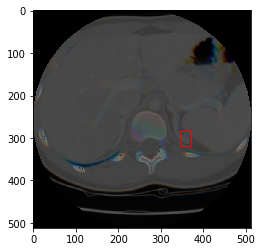

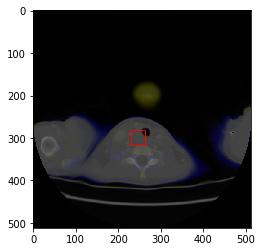

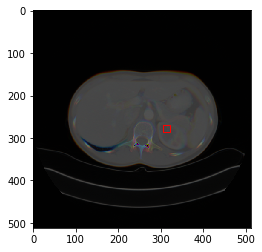

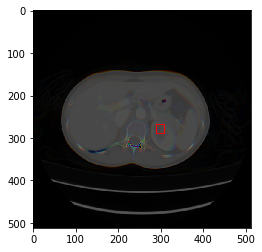

torch.Size([512, 512, 3])


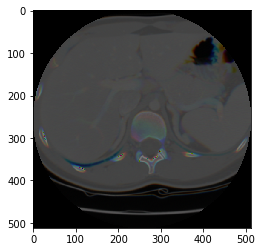

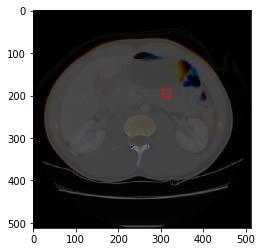

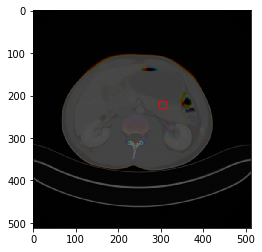

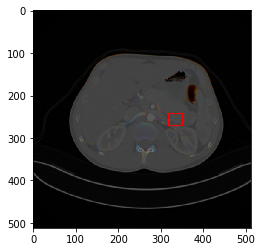

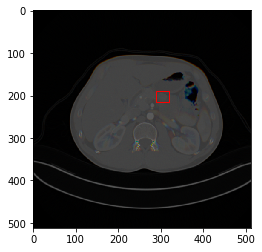

torch.Size([512, 512, 3])


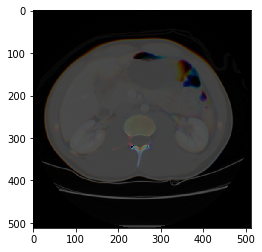

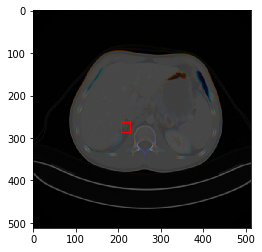

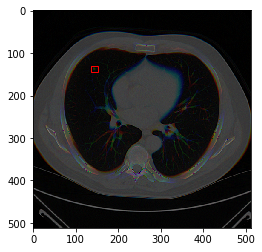

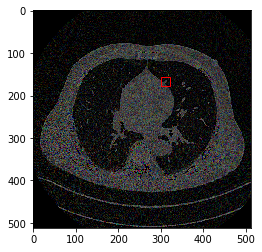

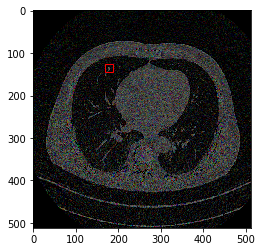

torch.Size([512, 512, 3])


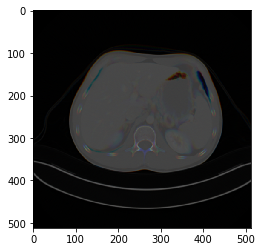

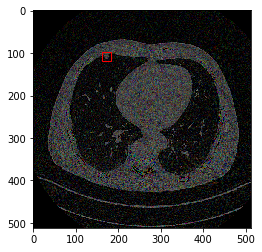

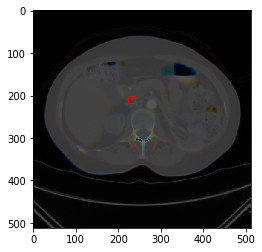

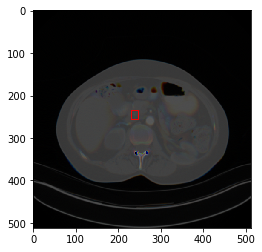

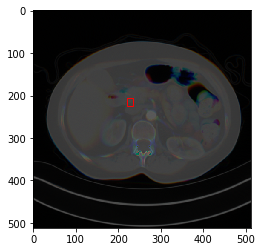

torch.Size([512, 512, 3])


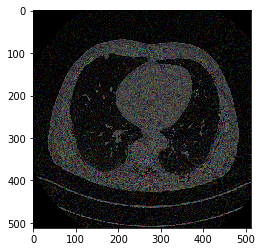

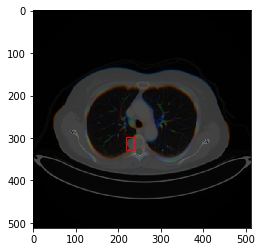

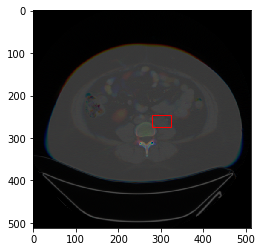

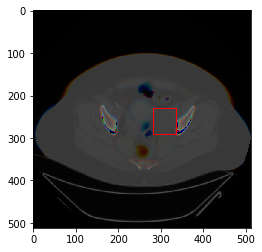

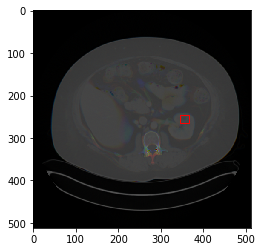

torch.Size([512, 512, 3])


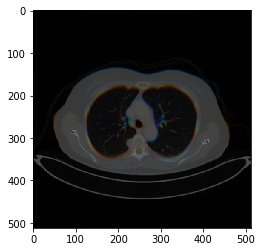

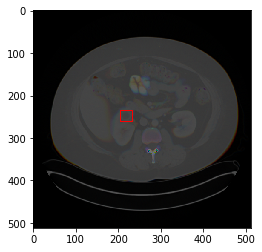

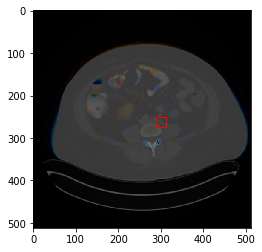

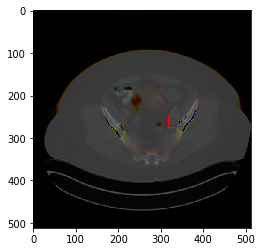

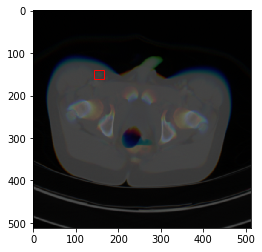

torch.Size([512, 512, 3])


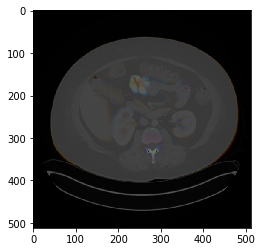

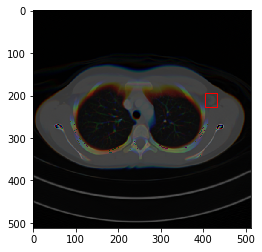

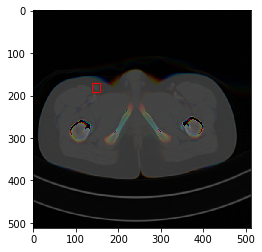

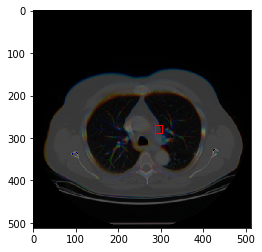

torch.Size([512, 512, 3])


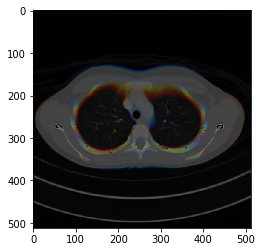

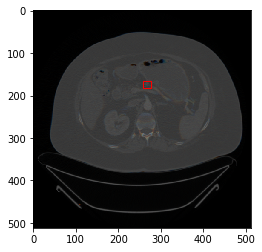

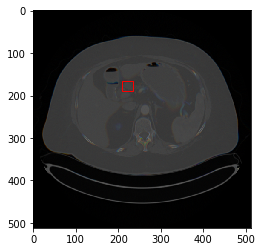

torch.Size([512, 512, 3])


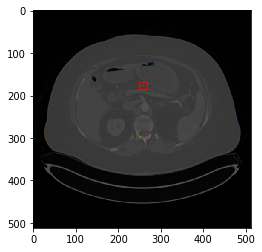

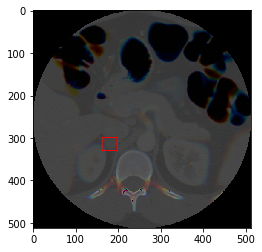

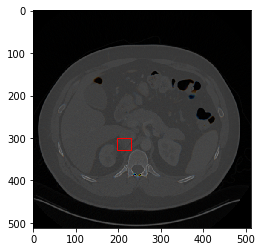

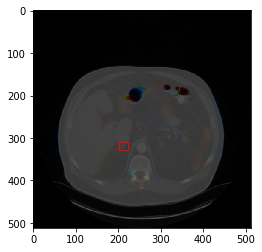

torch.Size([512, 512, 3])


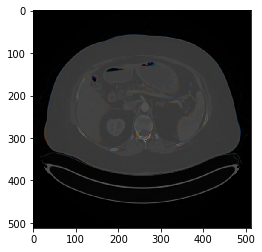

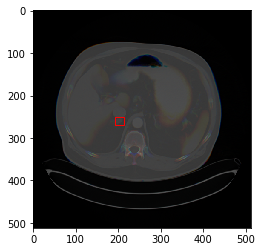

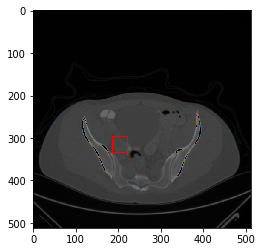

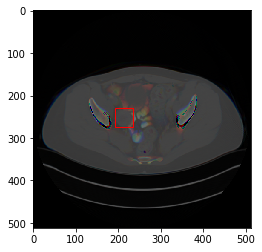

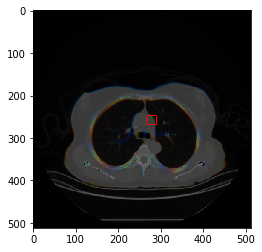

torch.Size([512, 512, 3])


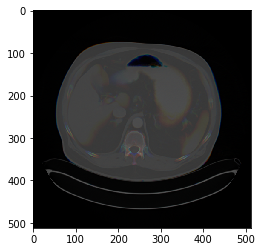

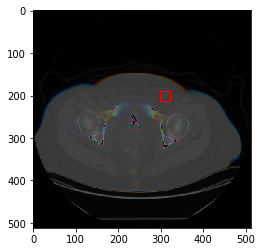

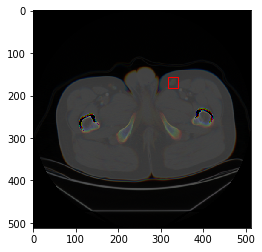

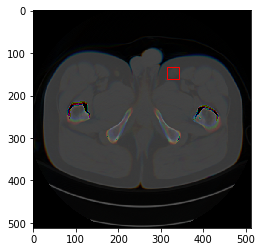

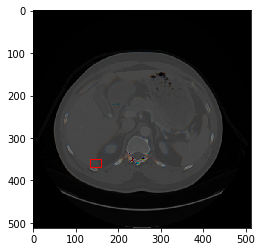

torch.Size([512, 512, 3])


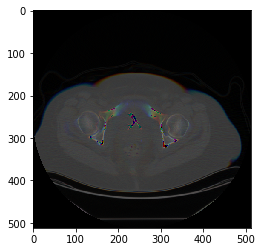

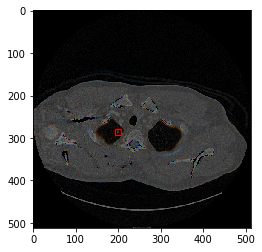

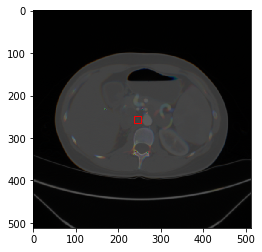

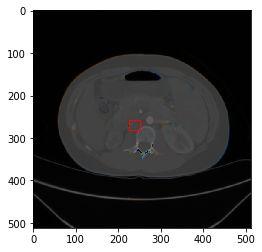

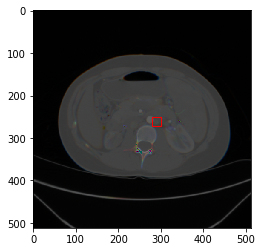

torch.Size([512, 512, 3])


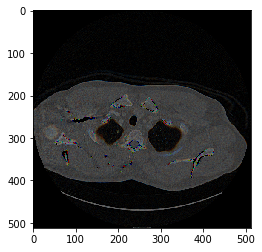

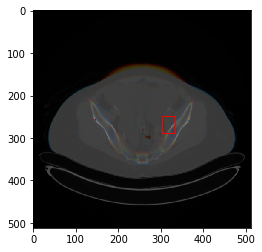

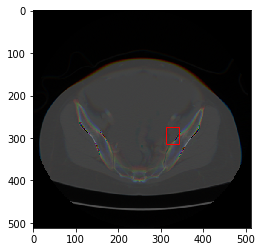

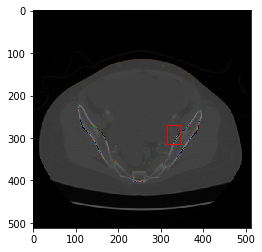

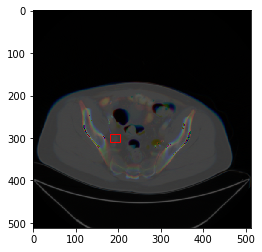

torch.Size([512, 512, 3])


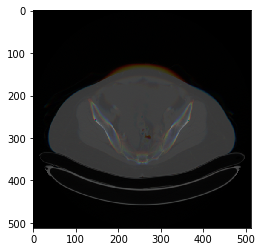

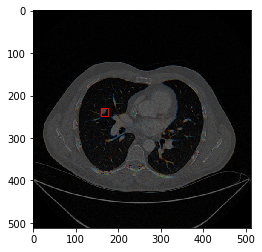

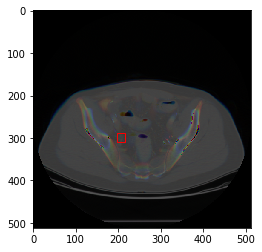

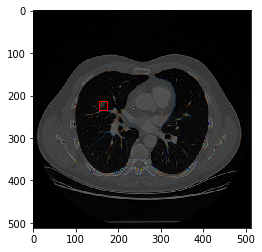

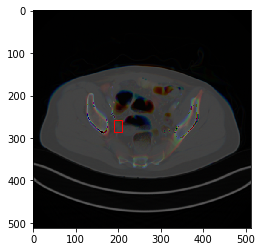

torch.Size([512, 512, 3])


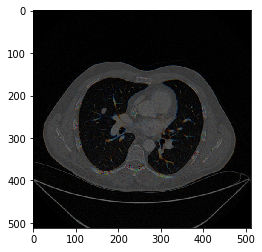

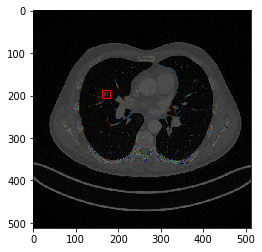

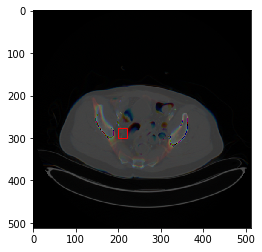

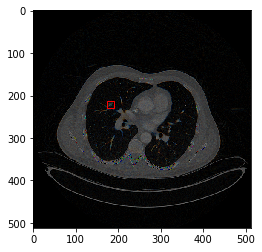

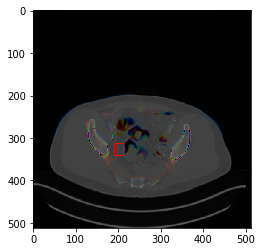

torch.Size([512, 512, 3])


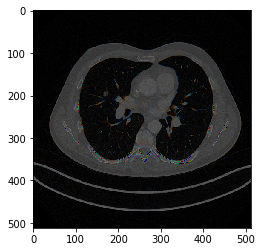

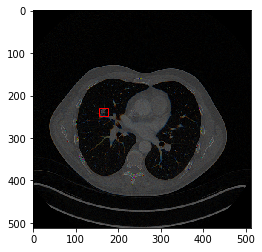

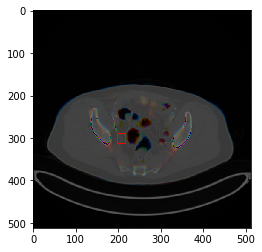

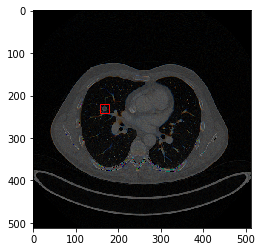

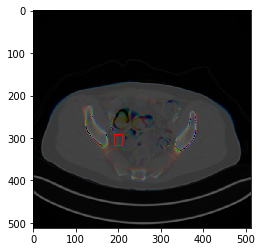

torch.Size([512, 512, 3])


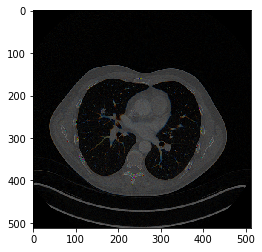

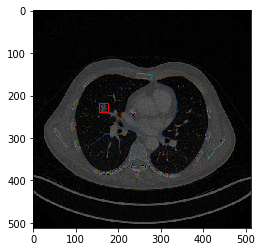

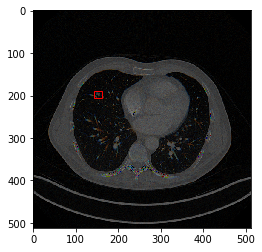

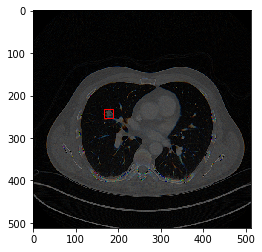

torch.Size([512, 512, 3])


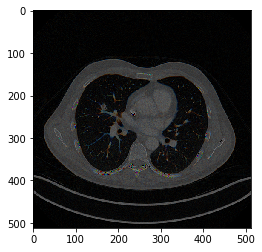

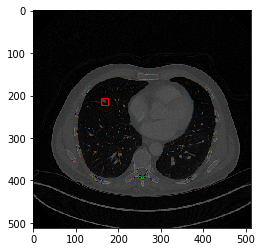

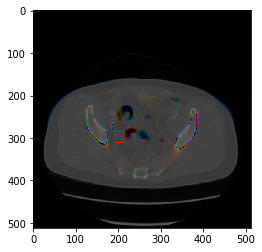

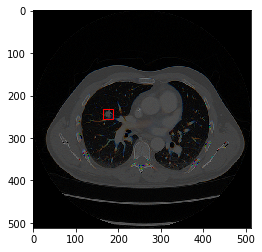

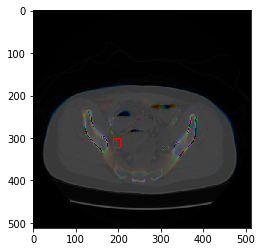

torch.Size([512, 512, 3])


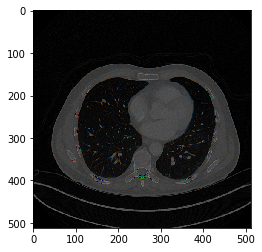

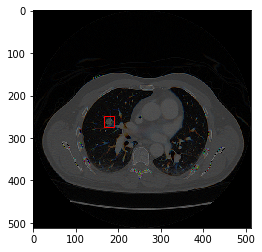

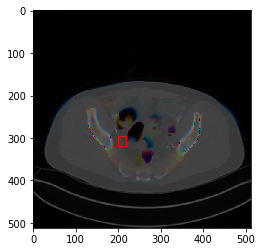

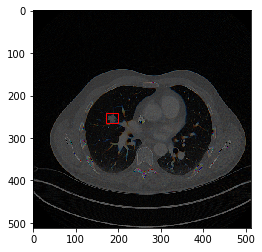

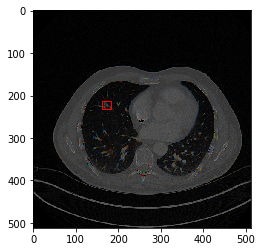

torch.Size([512, 512, 3])


KeyboardInterrupt: 

In [20]:
#model = model.cpu()
for sample_batched in dataloader:
    img = sample_batched['image'][0]
    print (img.shape)
#    img = img.view(512, 512, 3)
#    img = img.numpy().transpose(1,2,0)
    plt.imshow(img)
    plt.show()